# Detecting Gravitational Waves with LIGO Data

This notebook shows how gravitational waves can be detected, using data from the Laser Interferometer Gravitational-Wave Observatory (LIGO).  The data can be found on LIGO's website, along with tutorials on interpreting the data. 

https://www.ligo.caltech.edu/

The specific data files used by this notebook can be found on the Gravitational Wave Open Science Center:  https://www.gw-openscience.org/catalog/GWTC-1-confident/single/GW150914/

The Gravitational Wave Open Science Center also provides tutorials on interpreting the data that are extremely helpful: https://www.gw-openscience.org/tutorials/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import librosa
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
from scipy.io import wavfile
from scipy import signal

# Reading and Exploring Data

In [2]:
# Read the file for the first detector to extract strain data and create a time array
fileName = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
dataFile = h5py.File(fileName, 'r')
print(list(dataFile.keys()))

['meta', 'quality', 'strain']


In [3]:
# Explore each key's values
print(list(dataFile['meta'].keys()))
print(list(dataFile['quality'].keys()))
print(list(dataFile['strain'].keys()))
print(list(dataFile['strain']['Strain'].attrs))

['Description', 'DescriptionURL', 'Detector', 'Duration', 'GPSstart', 'Observatory', 'Type', 'UTCstart']
['detail', 'injections', 'simple']
['Strain']
['Npoints', 'Xlabel', 'Xspacing', 'Xstart', 'Xunits', 'Ylabel', 'Yunits']


It quickly becomes apparent that the file has a hierarchical structure with many levels. A HDF5 file can be viewed using a tool like PyHexad to determine which keys to extract. But to save time, the keys have already been identified from the dataset documentation.  The next cell extracts the specific keys needed.

In [4]:
# Get the actual strain values and the time interval
hstrain = dataFile['strain']['Strain'][()]
htime_interval = dataFile['strain']['Strain'].attrs['Xspacing']

We now know the time interval between samples. To get the actual time of each sample, we need to know the start time and duration of the signal. We know the duration is 32 seconds, but even if we did not know, these values can be found in the file’s metadata.

In [5]:
# View the meta data to see what the attributes for start time and duration are
metaKeys = dataFile['meta'].keys()
meta = dataFile['meta']
for key in metaKeys:
    print (key, meta[key][()])

Description b'Strain data time series from LIGO'
DescriptionURL b'http://losc.ligo.org/'
Detector b'H1'
Duration 32
GPSstart 1126259446
Observatory b'H'
Type b'StrainTimeSeries'
UTCstart b'2015-09-14T09:50:30'


So the start time (UTC) is 2015-09-14T09:50:30 and the duration is 32 seconds, putting the end time at 2015-09-14T09:51:02. Instead of UTC, we will use the GPS time because it will be easier to work with. We can now create a numpy array that starts at the start time, ends at the end time, and increments at a value of htime_interval.

In [7]:
# Create time vector for the detector based on start time and duration
gpsStart = meta['GPSstart'][()]
duration = meta['Duration'][()]
gpsEnd = gpsStart + duration
htime = np.arange(gpsStart, gpsEnd, htime_interval)

dataFile.close()

Do the same thing for the second strain (extract the strain and time values).  There's no need to explore the data anymore, since that was already done for the first strain and they are structured the same way.

In [8]:
# Read the file for the second detector to extract strain data and create a time array
fileName = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
dataFile = h5py.File(fileName, 'r')
lstrain = dataFile['strain']['Strain'][()]
ltime_interval = dataFile['strain']['Strain'].attrs['Xspacing']
ltime = np.arange(gpsStart, gpsEnd, ltime_interval)
dataFile.close()

In [9]:
# Read the template to serve as a reference
reftime, ref_H1 = np.genfromtxt('GW150914_4_NR_waveform_template.txt').transpose()

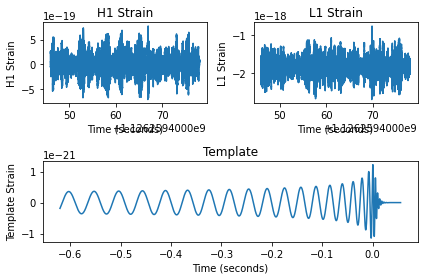

In [10]:
# Plot the detector strains and the template for comparison
fig = plt.figure()
numSamples = len(hstrain)
plth = fig.add_subplot(221)
plth.plot(htime[0:numSamples], hstrain[0:numSamples])
plth.set_xlabel('Time (seconds)')
plth.set_ylabel('H1 Strain')
plth.set_title('H1 Strain')
numSamples = len(lstrain)
pltl = fig.add_subplot(222)
pltl.plot(ltime[0:numSamples], lstrain[0:numSamples])
pltl.set_xlabel('Time (seconds)')
pltl.set_ylabel('L1 Strain')
pltl.set_title('L1 Strain')
pltref = fig.add_subplot(212)
pltref.plot(reftime, ref_H1)
pltref.set_xlabel('Time (seconds)')
pltref.set_ylabel('Template Strain')
pltref.set_title('Template')
fig.tight_layout()
plt.show()
plt.close(fig)

The H1 and L1 strains are quite noisy, as expected. Notice how clean the reference strain is – it is necessary for the reference template to be as pure as possible for any kind of signal processing problem
where a signal is to be identified by matching it with a template. Also notice that the plot for the reference template has negative time. That is because the template shows how the strain should look
leading up to the event (the collision of the black holes). The event itself occurs at time = 0.

# Cleaning the Data (Noise Removal)

At this point, it would normally be good to check the signal data for missing values. Fortunately, LIGO has already done the heavy lifting and there are no missing values during this 32 second time period for either detector. So the next step is to remove the noise to reveal the signal hidden in each strain. One step we can take to clean the data is compare the spectrum of the reference template to the spectrum of the strains.

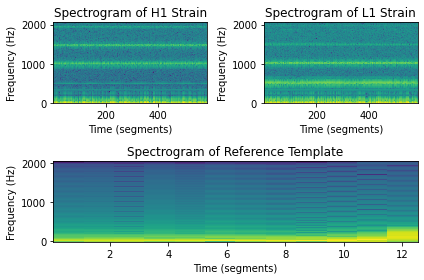

In [22]:
# Specify the sampling frequency to use for Fourier transformation
samplefreq = int(1/htime_interval)  # 4096

# Plot spectrogram for each strain and the template
h1samplefreqs, h1segtimes, h1sxx = signal.spectrogram(
    hstrain, fs=samplefreq
)
l1samplefreqs, l1segtimes, l1sxx = signal.spectrogram(
    lstrain, fs=samplefreq
)
refsamplefreqs, refsegtimes, refsxx = signal.spectrogram(
    ref_H1, fs=samplefreq
)
fig = plt.figure()
plth = fig.add_subplot(221)
plth.pcolormesh(
    (len(h1segtimes) * h1segtimes / h1segtimes[-1]),
    h1samplefreqs,
    10 * np.log10(h1sxx),
    shading='auto'
)
plth.set_xlabel('Time (segments)')
plth.set_ylabel('Frequency (Hz)')
plth.set_title('Spectrogram of H1 Strain')
pltl = fig.add_subplot(222)
pltl.pcolormesh(
    (len(l1segtimes) * l1segtimes / l1segtimes[-1]),
    l1samplefreqs,
    10 * np.log10(l1sxx),
    shading='auto'
)
pltl.set_xlabel('Time (segments)')
pltl.set_ylabel('Frequency (Hz)')
pltl.set_title('Spectrogram of L1 Strain')
pltref = fig.add_subplot(212)
pltref.pcolormesh(
    (len(refsegtimes) * refsegtimes / refsegtimes[-1]),
    refsamplefreqs,
    10 * np.log10(refsxx),
    shading='auto'
)
pltref.set_xlabel('Time (segments)')
pltref.set_ylabel('Frequency (Hz)')
pltref.set_title('Spectrogram of Reference Template')
fig.tight_layout()
plt.show()
plt.close(fig)

By plotting the spectrograms, we can see which frequencies are strongest in each signal. Right away it becomes obvious that the reference template has virtually no power in frequencies above 500 Hz. In fact, the expected frequency of gravity waves from colliding black holes is near 0. If we were to listen to it as an audio file, it would sound like a very low, bass heavy blip, almost like a heartbeat. We know it will be just a blip because the x-axis, the timespan of the reference template, is very short. Looking at the strain signals, we can see that they contain energy in higher frequency bands. The higher frequencies can be removed by a low pass filter.

/home/nick/Desktop/signals/env/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


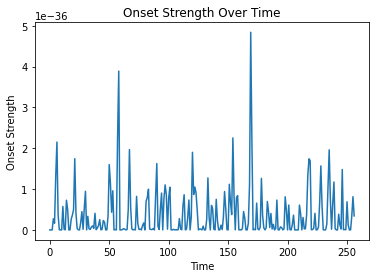

In [26]:
def plotSpecEnvelope(wav, samplefreq):
    """
    The onset envelope, oenv, determines the start points for patterns.
    """
    mel = librosa.feature.melspectrogram(y=wav, sr=samplefreq, n_mels=128, fmax=30000)
    oenv = librosa.onset.onset_strength(y=wav, sr=samplefreq, S=mel)
    plt.plot(oenv, label='Onset strength')
    plt.title('Onset Strength Over Time')
    plt.xlabel('Time')
    plt.ylabel('Onset Strength')
    plt.show()
    return oenv

# Plot the spectral envelope of the H1 strain
h1_onset_env = plotSpecEnvelope(hstrain, samplefreq)

The power spectral density (PSD) shows how much energy or power lies within each range of frequencies that make up a signal. Signals can be analyzed from the time domain or frequency domain, and the PSD is like the spectral version of autorrelation. We can plot the periodograms for the strain signals and the reference template to see how energy varies by frequency.

LIGO uses the amplitude spectral density (ASD) instead of the PSD. The ASD is simply the square root of the PSD. These plots will give us a much clearer picture of which frequencies are powerful for each signal. They are simply refinements of the spectrograms.

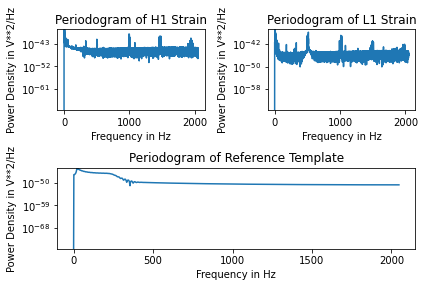

In [27]:
# Plot periodograms for each strain and the template
h1freq, h1power_density = signal.periodogram(hstrain, fs=samplefreq)
l1freq, l1power_density = signal.periodogram(lstrain, fs=samplefreq)
reffreq, refpower_density = signal.periodogram(ref_H1, fs=samplefreq)
fig = plt.figure()
plth = fig.add_subplot(221)
plth.semilogy(h1freq, h1power_density)
plth.set_ylim([np.min(h1power_density), np.max(h1power_density)])
plth.set_xlabel('Frequency in Hz')
plth.set_ylabel('Power Density in V**2/Hz')
plth.set_title('Periodogram of H1 Strain')
pltl = fig.add_subplot(222)
pltl.semilogy(l1freq, l1power_density)
pltl.set_ylim([np.min(l1power_density), np.max(l1power_density)])
pltl.set_xlabel('Frequency in Hz')
pltl.set_ylabel('Power Density in V**2/Hz')
pltl.set_title('Periodogram of L1 Strain')
pltref = fig.add_subplot(212)
pltref.semilogy(reffreq, refpower_density)
pltref.set_ylim([np.min(refpower_density), np.max(refpower_density)])
pltref.set_xlabel('Frequency in Hz')
pltref.set_ylabel('Power Density in V**2/Hz')
pltref.set_title('Periodogram of Reference Template')
fig.tight_layout()
plt.show()
plt.close(fig)

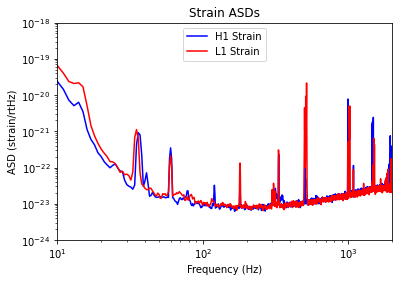

In [28]:
# Compute and plot the ASD for each detector strain
pxx_H1, freqs = mlab.psd(hstrain, Fs=samplefreq, NFFT=samplefreq)
pxx_L1, freqs = mlab.psd(lstrain, Fs=samplefreq, NFFT=samplefreq)
plt.figure()
plt.loglog(freqs, np.sqrt(pxx_H1), 'b', label='H1 Strain')
plt.loglog(freqs, np.sqrt(pxx_L1), 'r', label='L1 Strain')
plt.axis([10, 2000, 1e-24, 1e-18])
plt.legend(loc='upper center')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD (strain/rtHz)')
plt.title('Strain ASDs')
plt.show()
plt.close()

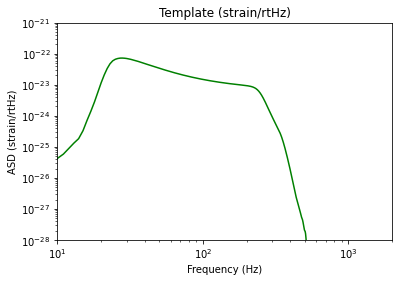

In [29]:
# Store interpolations of the ASDs computed above to use later for whitening
psd_H1 = interp1d(freqs, pxx_H1)
psd_L1 = interp1d(freqs, pxx_L1)

# Plot the reference template ASD for comparison
pxx_ref, freqs = mlab.psd(ref_H1, Fs=samplefreq, NFFT=samplefreq)
plt.loglog(freqs, np.sqrt(pxx_ref), 'g', label='Template Strain')
plt.axis([10, 2000, 1e-28, 1e-21])
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD (strain/rtHz)')
plt.title('Template (strain/rtHz)')
plt.show()
plt.close()

It is clear from the reference template that gravitational waves mostly lie in the spectrum of 20 Hz to 300 Hz. So a band pass filter would be helpful, because we can set the lower limit to 20 Hz. However, even if we apply a band pass, we will still have white noise in the lower frequencies of the strain data. So before applying the band pass, we can use a technique called whitening. Whitening is a way to get rid of background noise/white noise by calculating the inverse of the signal and applying it in order to cancel it out through destructive interference. 

In [30]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [31]:
# Whiten the data from H1, L1, and reference template
hstrain_whiten = whiten(hstrain, psd_H1, htime_interval)
lstrain_whiten = whiten(lstrain, psd_L1, ltime_interval)
ref_H1_whiten = whiten(ref_H1, psd_H1, htime_interval)

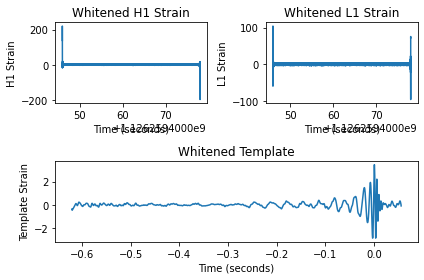

In [32]:
# Plot the cleaned detector strains
fig = plt.figure()
numSamples = len(hstrain_whiten)
plth = fig.add_subplot(221)
plth.plot(htime[0:numSamples], hstrain_whiten[0:numSamples])
plth.set_xlabel('Time (seconds)')
plth.set_ylabel('H1 Strain')
plth.set_title('Whitened H1 Strain')
numSamples = len(lstrain_whiten)
pltl = fig.add_subplot(222)
pltl.plot(ltime[0:numSamples], lstrain_whiten[0:numSamples])
pltl.set_xlabel('Time (seconds)')
pltl.set_ylabel('L1 Strain')
pltl.set_title('Whitened L1 Strain')
pltref = fig.add_subplot(212)
pltref.plot(reftime, ref_H1_whiten)
pltref.set_xlabel('Time (seconds)')
pltref.set_ylabel('Template Strain')
pltref.set_title('Whitened Template')
fig.tight_layout()
plt.show()
plt.close(fig)

A band pass to attenuate frequencies outside of the range of 20-300 Hz can then be applied to the whitened signals.

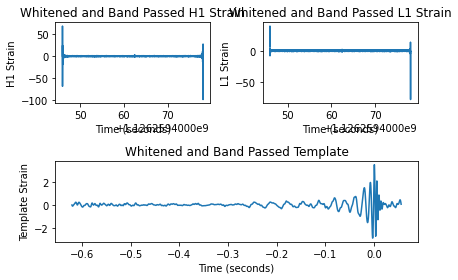

In [34]:
# Apply band pass to remove everything outside of the desired spectrum
(b,a) = butter(4, [20/(samplefreq/2.0), 300/(samplefreq/2.0)], btype='pass')
hstrain_whitenbp = filtfilt(b, a, hstrain_whiten)
lstrain_whitenbp = filtfilt(b, a, lstrain_whiten)
ref_H1_whitenbp = filtfilt(b, a, ref_H1_whiten)

# Plot the cleaned detector strains
fig = plt.figure()
numSamples = len(hstrain_whitenbp)
plth = fig.add_subplot(221)
plth.plot(htime[0:numSamples], hstrain_whitenbp[0:numSamples])
plth.set_xlabel('Time (seconds)')
plth.set_ylabel('H1 Strain')
plth.set_title('Whitened and Band Passed H1 Strain')
numSamples = len(lstrain_whitenbp)
pltl = fig.add_subplot(222)
pltl.plot(ltime[0:numSamples], lstrain_whitenbp[0:numSamples])
pltl.set_xlabel('Time (seconds)')
pltl.set_ylabel('L1 Strain')
pltl.set_title('Whitened and Band Passed L1 Strain')
pltref = fig.add_subplot(212)
pltref.plot(reftime, ref_H1_whitenbp)
pltref.set_xlabel('Time (seconds)')
pltref.set_ylabel('Template Strain')
pltref.set_title('Whitened and Band Passed Template')
fig.tight_layout()
plt.show()
plt.close(fig)

We can now see a little spike near the middle of each strain signal. That is the signal we are looking for, but at this point we do not yet know this for sure. The next step is to compare the strains to the reference template. 

# Finding the Signal with Template Matching

A cross correlation can be used to find any parts of the strain signals that match closely with the reference template. A cross correlation measures how similar two signals are by applying a sliding dot product along the length of the signals. Since the reference template has a different lengh than the strains, we set the mode to ‘valid’, meaning the shorter signal is move along the longer signal. When the signals overlap, their dot product will be maximized. If we plot the cross correlation, we will see spikes in the positive and negative directions when the template matches up to the strain signals. Note that this process can be applied to any kind of signal analysis where a template needs to be compared to a signal to determine if any part of the signal matches the template.

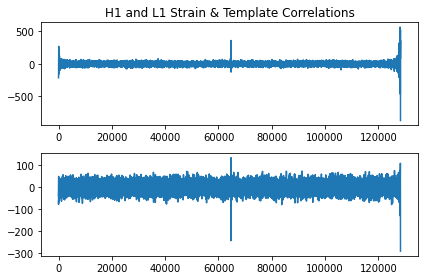

In [35]:
# Plot the cross correlation between each detection strain and the reference template
hcorr = np.correlate(hstrain_whitenbp, ref_H1_whitenbp, 'valid')
lcorr = np.correlate(lstrain_whitenbp, ref_H1_whitenbp, 'valid')
fig = plt.figure()
plthcorr = fig.add_subplot(211)
plthcorr.plot(hcorr)
pltlcorr = fig.add_subplot(212)
pltlcorr.plot(lcorr)
plthcorr.set_title('H1 and L1 Strain & Template Correlations')
fig.tight_layout()
plt.show()
plt.close(fig)

Looking at the plot of the cross correlation and the whitened strain plots, the event appears to have occurred between 20 and 25 seconds into the signal. Since the time period begins at 5 on the plot though, we must subtract 5 seconds from that range. We can plot the cross correlation of the H1 strain and reference template for that range, but adjusting the time axis a bit results in a better plot. After a few adjustments to zero in on the event, we can view the H1 and L1 strains compared to the reference template on the same plot.

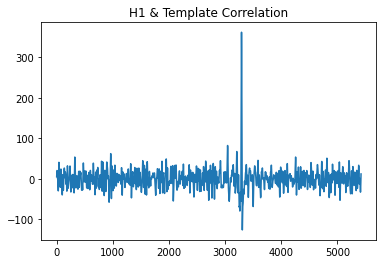

In [36]:
# Plot the whitened H1 strain-template strain correlation between 15 and 17 seconds
startind = np.where(htime==(min(htime)+15))[0][0]
endind = np.where(htime==(min(htime)+17))[0][0]
hcorr = np.correlate(
    hstrain_whitenbp[startind:endind], 
    ref_H1_whitenbp, 
    'valid'
)
plt.plot(hcorr)
plt.title('H1 & Template Correlation')
plt.show()

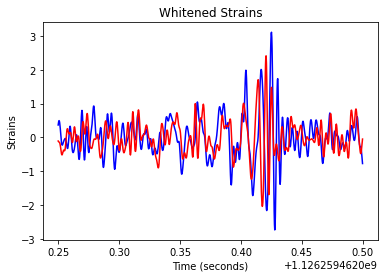

In [37]:
# Zero in on the event
startind = np.where(htime==(min(htime)+16.25))[0][0]
endind = np.where(htime==(min(htime)+16.5))[0][0]
plt.plot(
    htime[startind:endind], 
    hstrain_whitenbp[startind:endind], 
    'b', 
    label='H1 Strain'
)
plt.plot(
    htime[startind:endind], 
    lstrain_whitenbp[startind:endind], 
    'r', 
    label='L1 Strain'
)
plt.xlabel('Time (seconds)')
plt.ylabel('Strains')
plt.title('Whitened Strains')
plt.show()

The plots show that the H1 and L1 strains align very closely in this time interval. That means that whatever the event was, it was detected simultaneously by both observatories. This helps rule out the possibility that the event was a mistake, like a construction worker dropping a hammer nearby. Now that we have a good idea where the event occurred in the signal, we can cheat by looking at the actual
time of the event provided by LIGO: Monday September 14, 2015 09:40:45 GMT. If we plot our cleaned strain signals and the reference template for a few time points around that event time, we can see that everything matches up closely. We can be confident that we have found a gravitational wave signal.

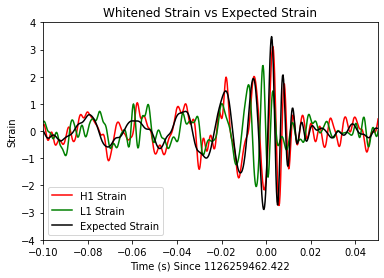

In [38]:
# Using the time of the event provided by LIGO, see if we found it
tevent = 1126259462.422     #Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.                 #Seconds around the event
indxt = np.where((htime >= tevent-deltat) & (htime < tevent+deltat))
plt.figure()
plt.plot(htime-tevent, hstrain_whitenbp,'r', label='H1 Strain')
plt.plot(htime-tevent, lstrain_whitenbp,'g', label='L1 Strain')
plt.plot(reftime+0.002, ref_H1_whitenbp,'k', label='Expected Strain')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
plt.xlabel('Time (s) Since '+str(tevent))
plt.ylabel('Strain')
plt.legend(loc='lower left')
plt.title('Whitened Strain vs Expected Strain')
plt.show()

# Export the signal to a .wav File

In [39]:
def write_wav(data, samplefreq, filename):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename, int(samplefreq), d)

In [ ]:
# Write a wav file for each detector strain and the template
write_wav(hstrain_whitenbp[indxt], samplefreq, "H1_whitenbp.wav")
write_wav(lstrain_whitenbp[indxt], samplefreq, "L1_whitenbp.wav")
write_wav(ref_H1_whitenbp, samplefreq, "Ref_Template_whitenbp.wav")